### Configure API keys

To fine-tune YOLO26, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Runtime` -> `Change runtime type` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Feb 12 11:23:42 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             14W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies required for YOLO26

In [3]:
%pip install -q "ultralytics>=8.4.0" supervision roboflow

# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.8/112.6 GB disk)


### Download example data

Downloads example images for testing. You can use these or replace them with your own images.

In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="yqJsZf2n2P8Hh9rtOaBv")
project = rf.workspace("rail-psseq").project("rail-hp8ij")
version = project.version(6)
dataset = version.download("yolo26")


loading Roboflow workspace...
loading Roboflow project...


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [10]:
print(dataset.location)

/content/Rail-6


In [15]:
!yolo task=detect mode=predict model=yolo26m.pt source={dataset.location}/test/images/{selected_image} save=True verbose=False

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLO26m summary (fused): 132 layers, 20,411,132 parameters, 0 gradients, 68.2 GFLOPs
Results saved to /content/runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


### CLI

**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

First, let's list the images available in the test split of your downloaded dataset to pick one for inference.

In [17]:
import os

# Assuming the dataset has a 'test/images' directory
image_files = os.listdir(f"{dataset.location}/test/images")

if image_files:
    selected_image = image_files[0] # Pick the first image found
    print(f"Selected image for inference: {selected_image}")
else:
    selected_image = None
    print("No images found in the test directory.")

Selected image for inference: s17_JPG.rf.213bfc9147850d9cb4c5058a3ad45b12.jpg


In [18]:
!ls -la {HOME}/runs/detect/predict/

total 96
drwxr-xr-x 2 root root  4096 Feb 12 11:31 .
drwxr-xr-x 3 root root  4096 Feb 12 11:30 ..
-rw-r--r-- 1 root root 87395 Feb 12 11:31 s17_JPG.rf.213bfc9147850d9cb4c5058a3ad45b12.jpg


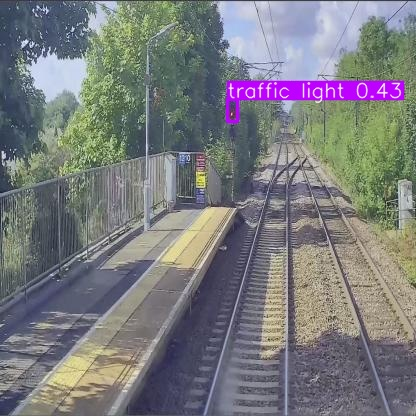

In [22]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/{selected_image}', width=600)

### SDK

In [23]:
from ultralytics import YOLO
from PIL import Image

model = YOLO('yolo26m.pt')
image = Image.open(f'{dataset.location}/test/images/{selected_image}')
result = model.predict(image, verbose=False)[0]

**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [24]:
result.boxes.xyxy

tensor([[227.0542,  99.3167, 237.0917, 121.3224]], device='cuda:0')

In [25]:
result.boxes.conf

tensor([0.4305], device='cuda:0')

In [26]:
result.boxes.cls

tensor([9.], device='cuda:0')

**NOTE:** YOLO26 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [27]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

In [28]:
import supervision as sv
from PIL import Image

def annotate(image: Image.Image, detections: sv.Detections) -> Image.Image:
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        smart_position=True
    )

    out = image.copy()
    out = box_annotator.annotate(out, detections)
    out = label_annotator.annotate(out, detections)
    out.thumbnail((1000, 1000))
    return out

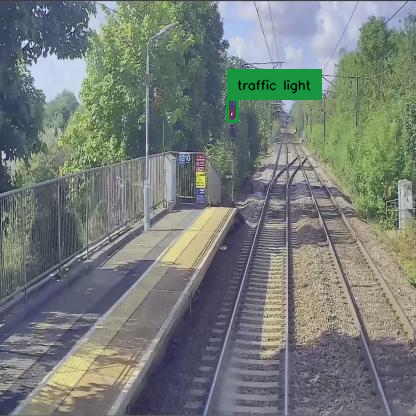

In [29]:
annotated_image = annotate(image, detections)
annotated_image

## Fine-tune YOLO26 on custom dataset

**NOTE:** When training YOLO26, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [31]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets


## Custom Training

In [32]:
%cd {HOME}

!yolo task=detect mode=train model=yolo26m.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 plots=True

/content
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Rail-6/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [33]:
!ls {HOME}/runs/detect/train/

args.yaml			 results.csv	     val_batch0_labels.jpg
BoxF1_curve.png			 results.png	     val_batch0_pred.jpg
BoxP_curve.png			 train_batch0.jpg    val_batch1_labels.jpg
BoxPR_curve.png			 train_batch1.jpg    val_batch1_pred.jpg
BoxR_curve.png			 train_batch2.jpg    val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch660.jpg  val_batch2_pred.jpg
confusion_matrix.png		 train_batch661.jpg  weights
labels.jpg			 train_batch662.jpg


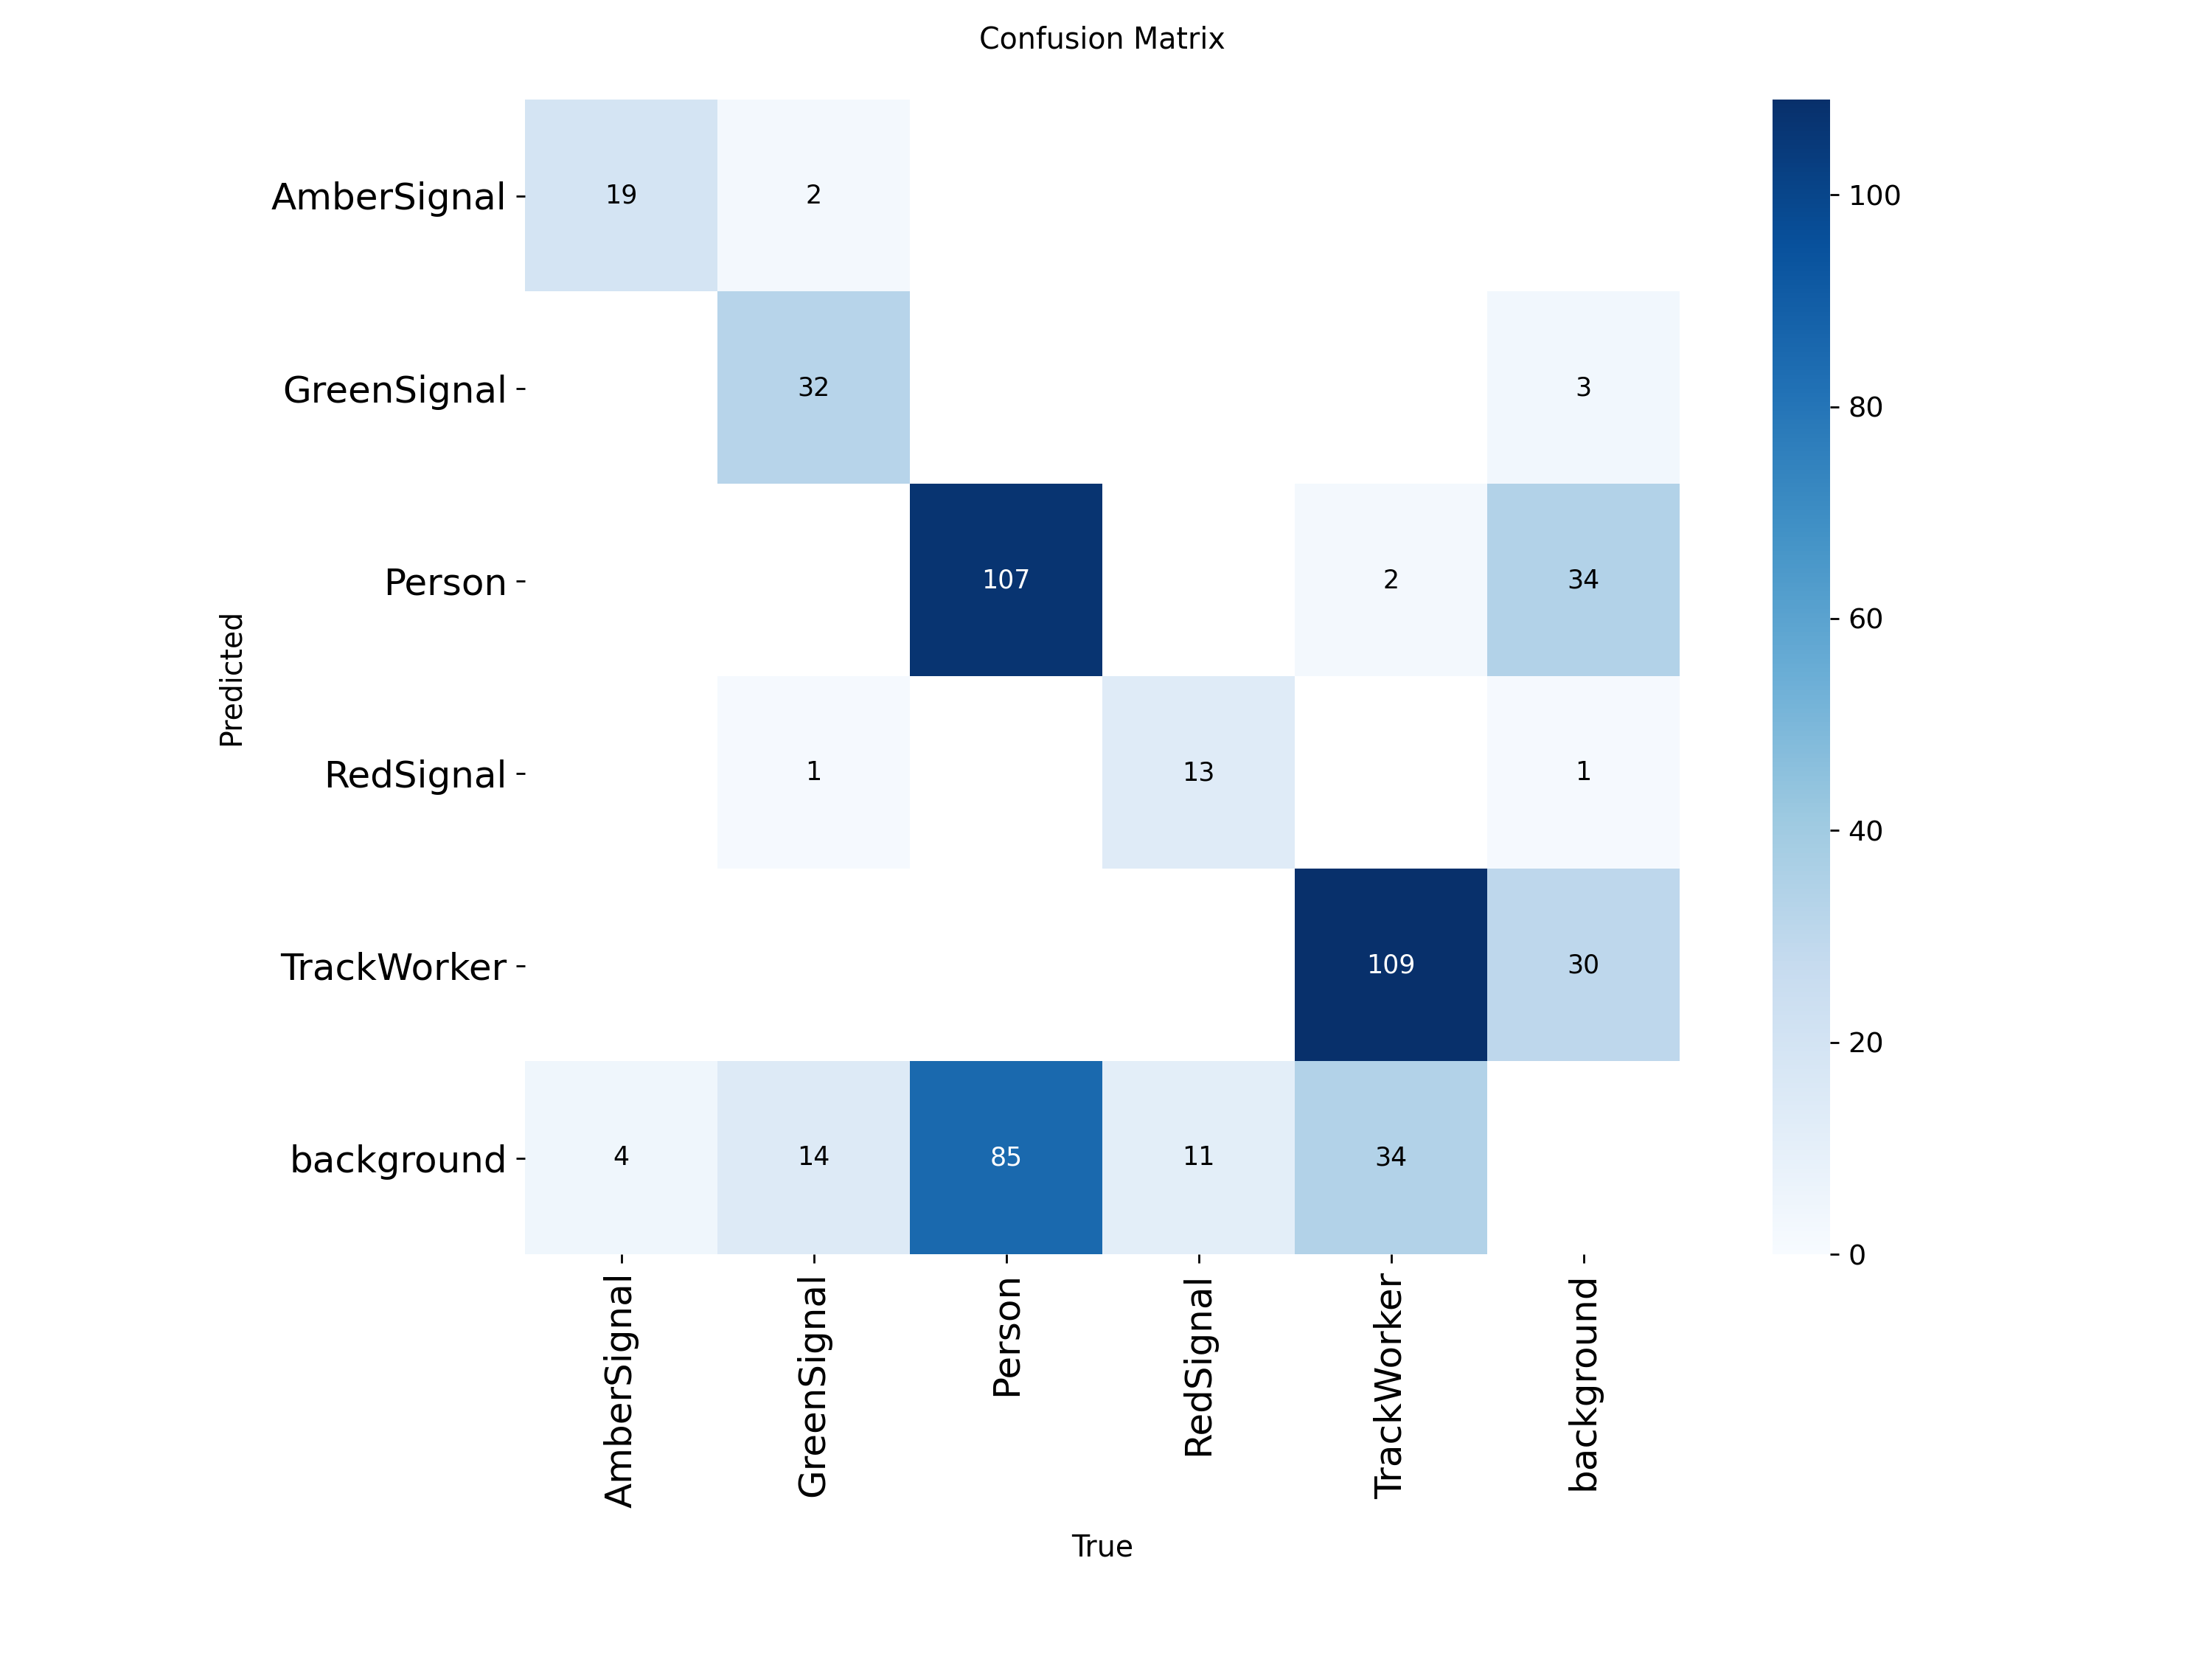

In [34]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

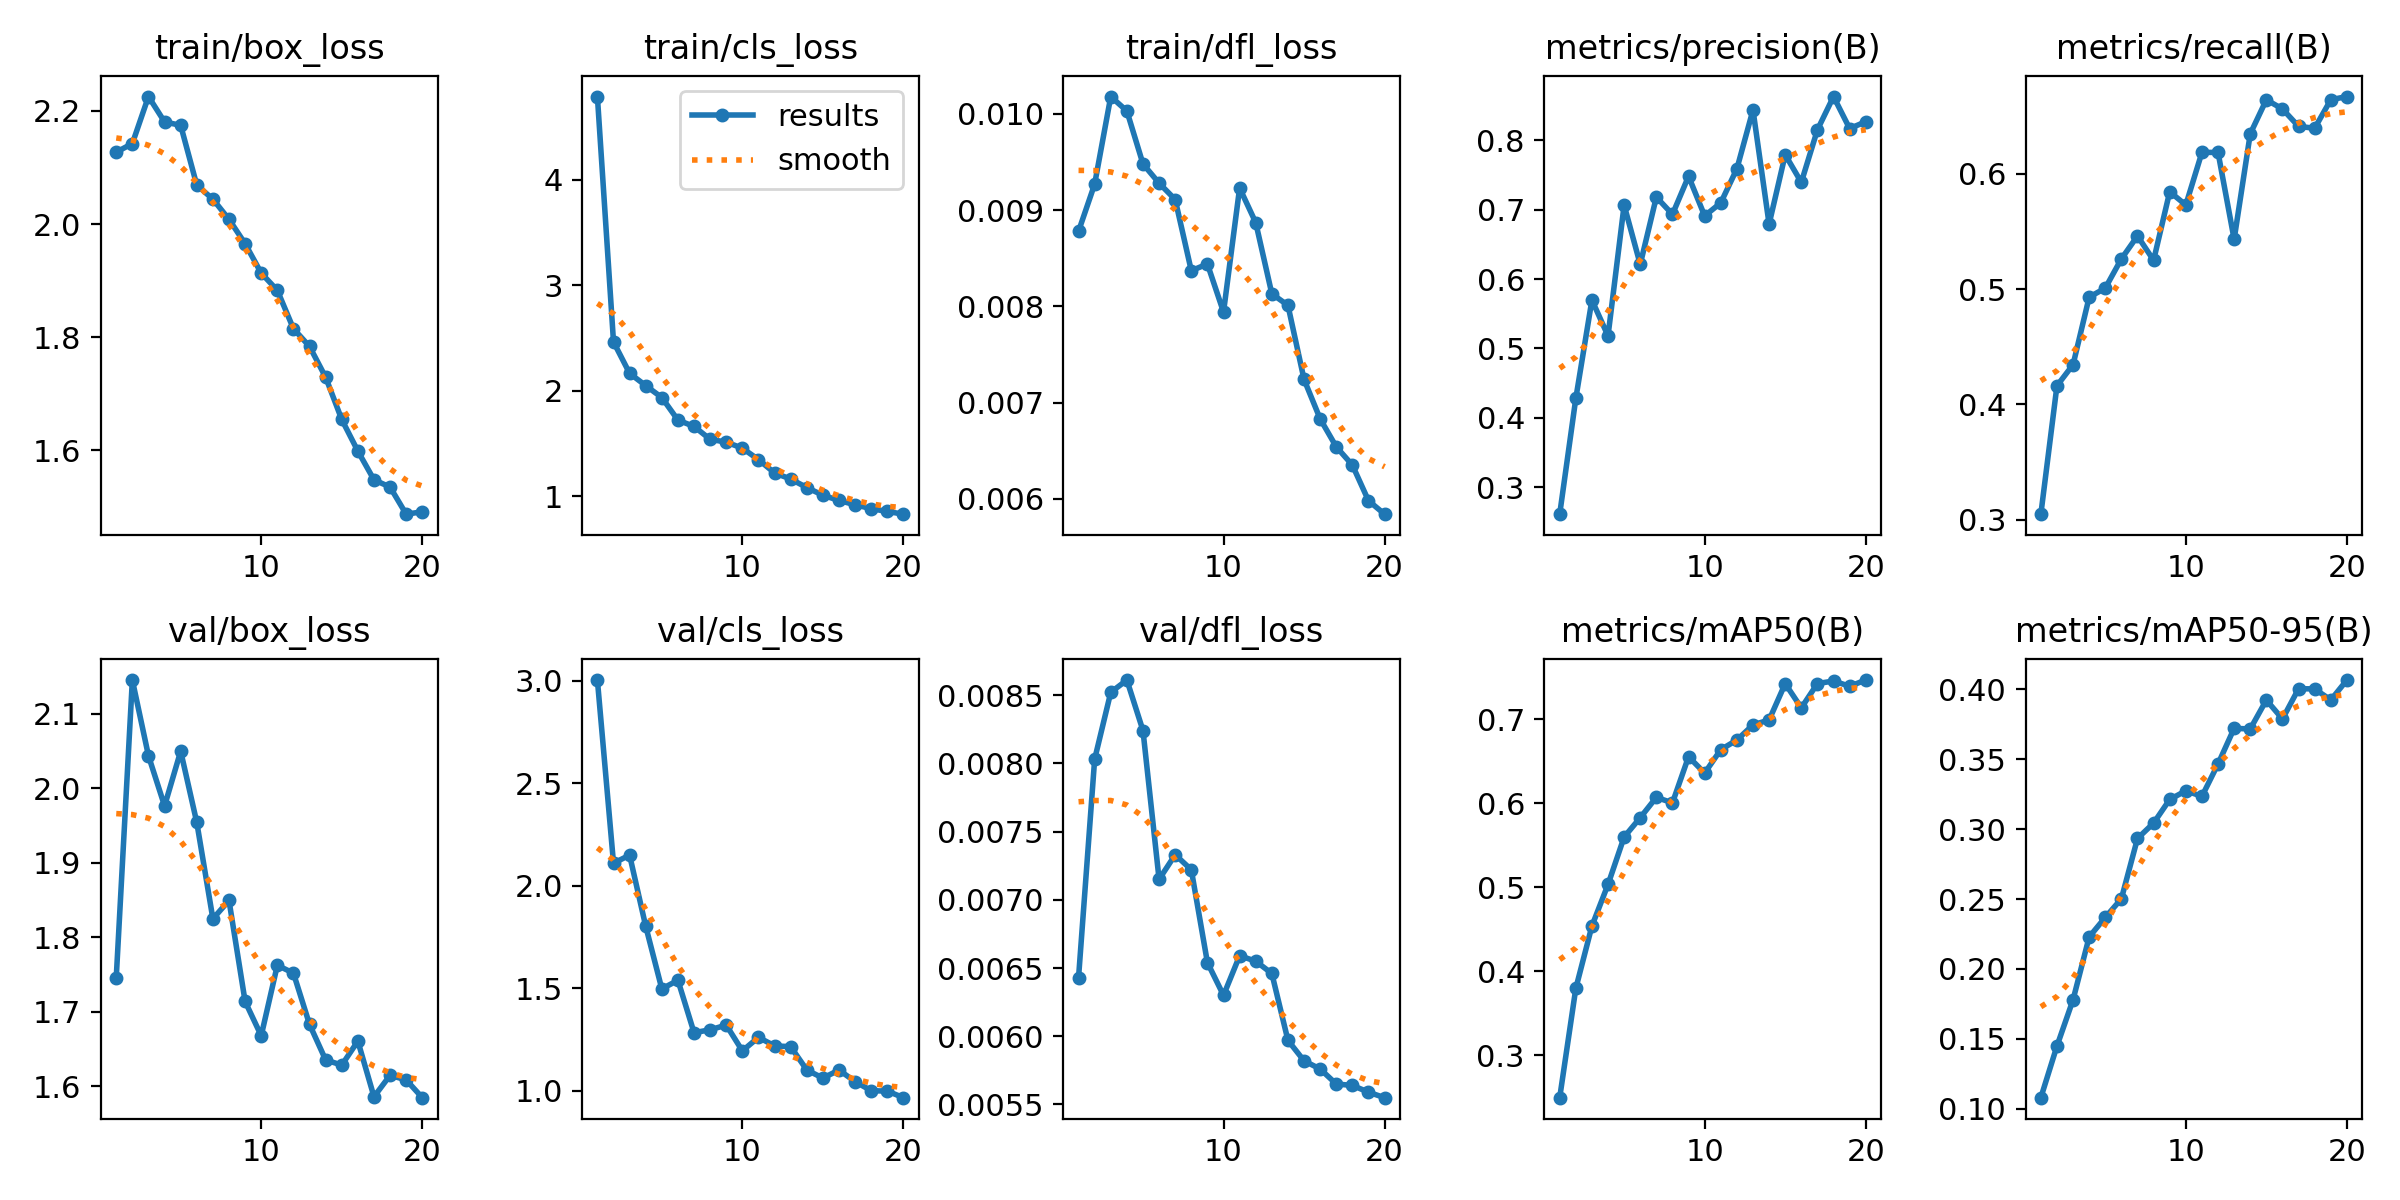

In [35]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

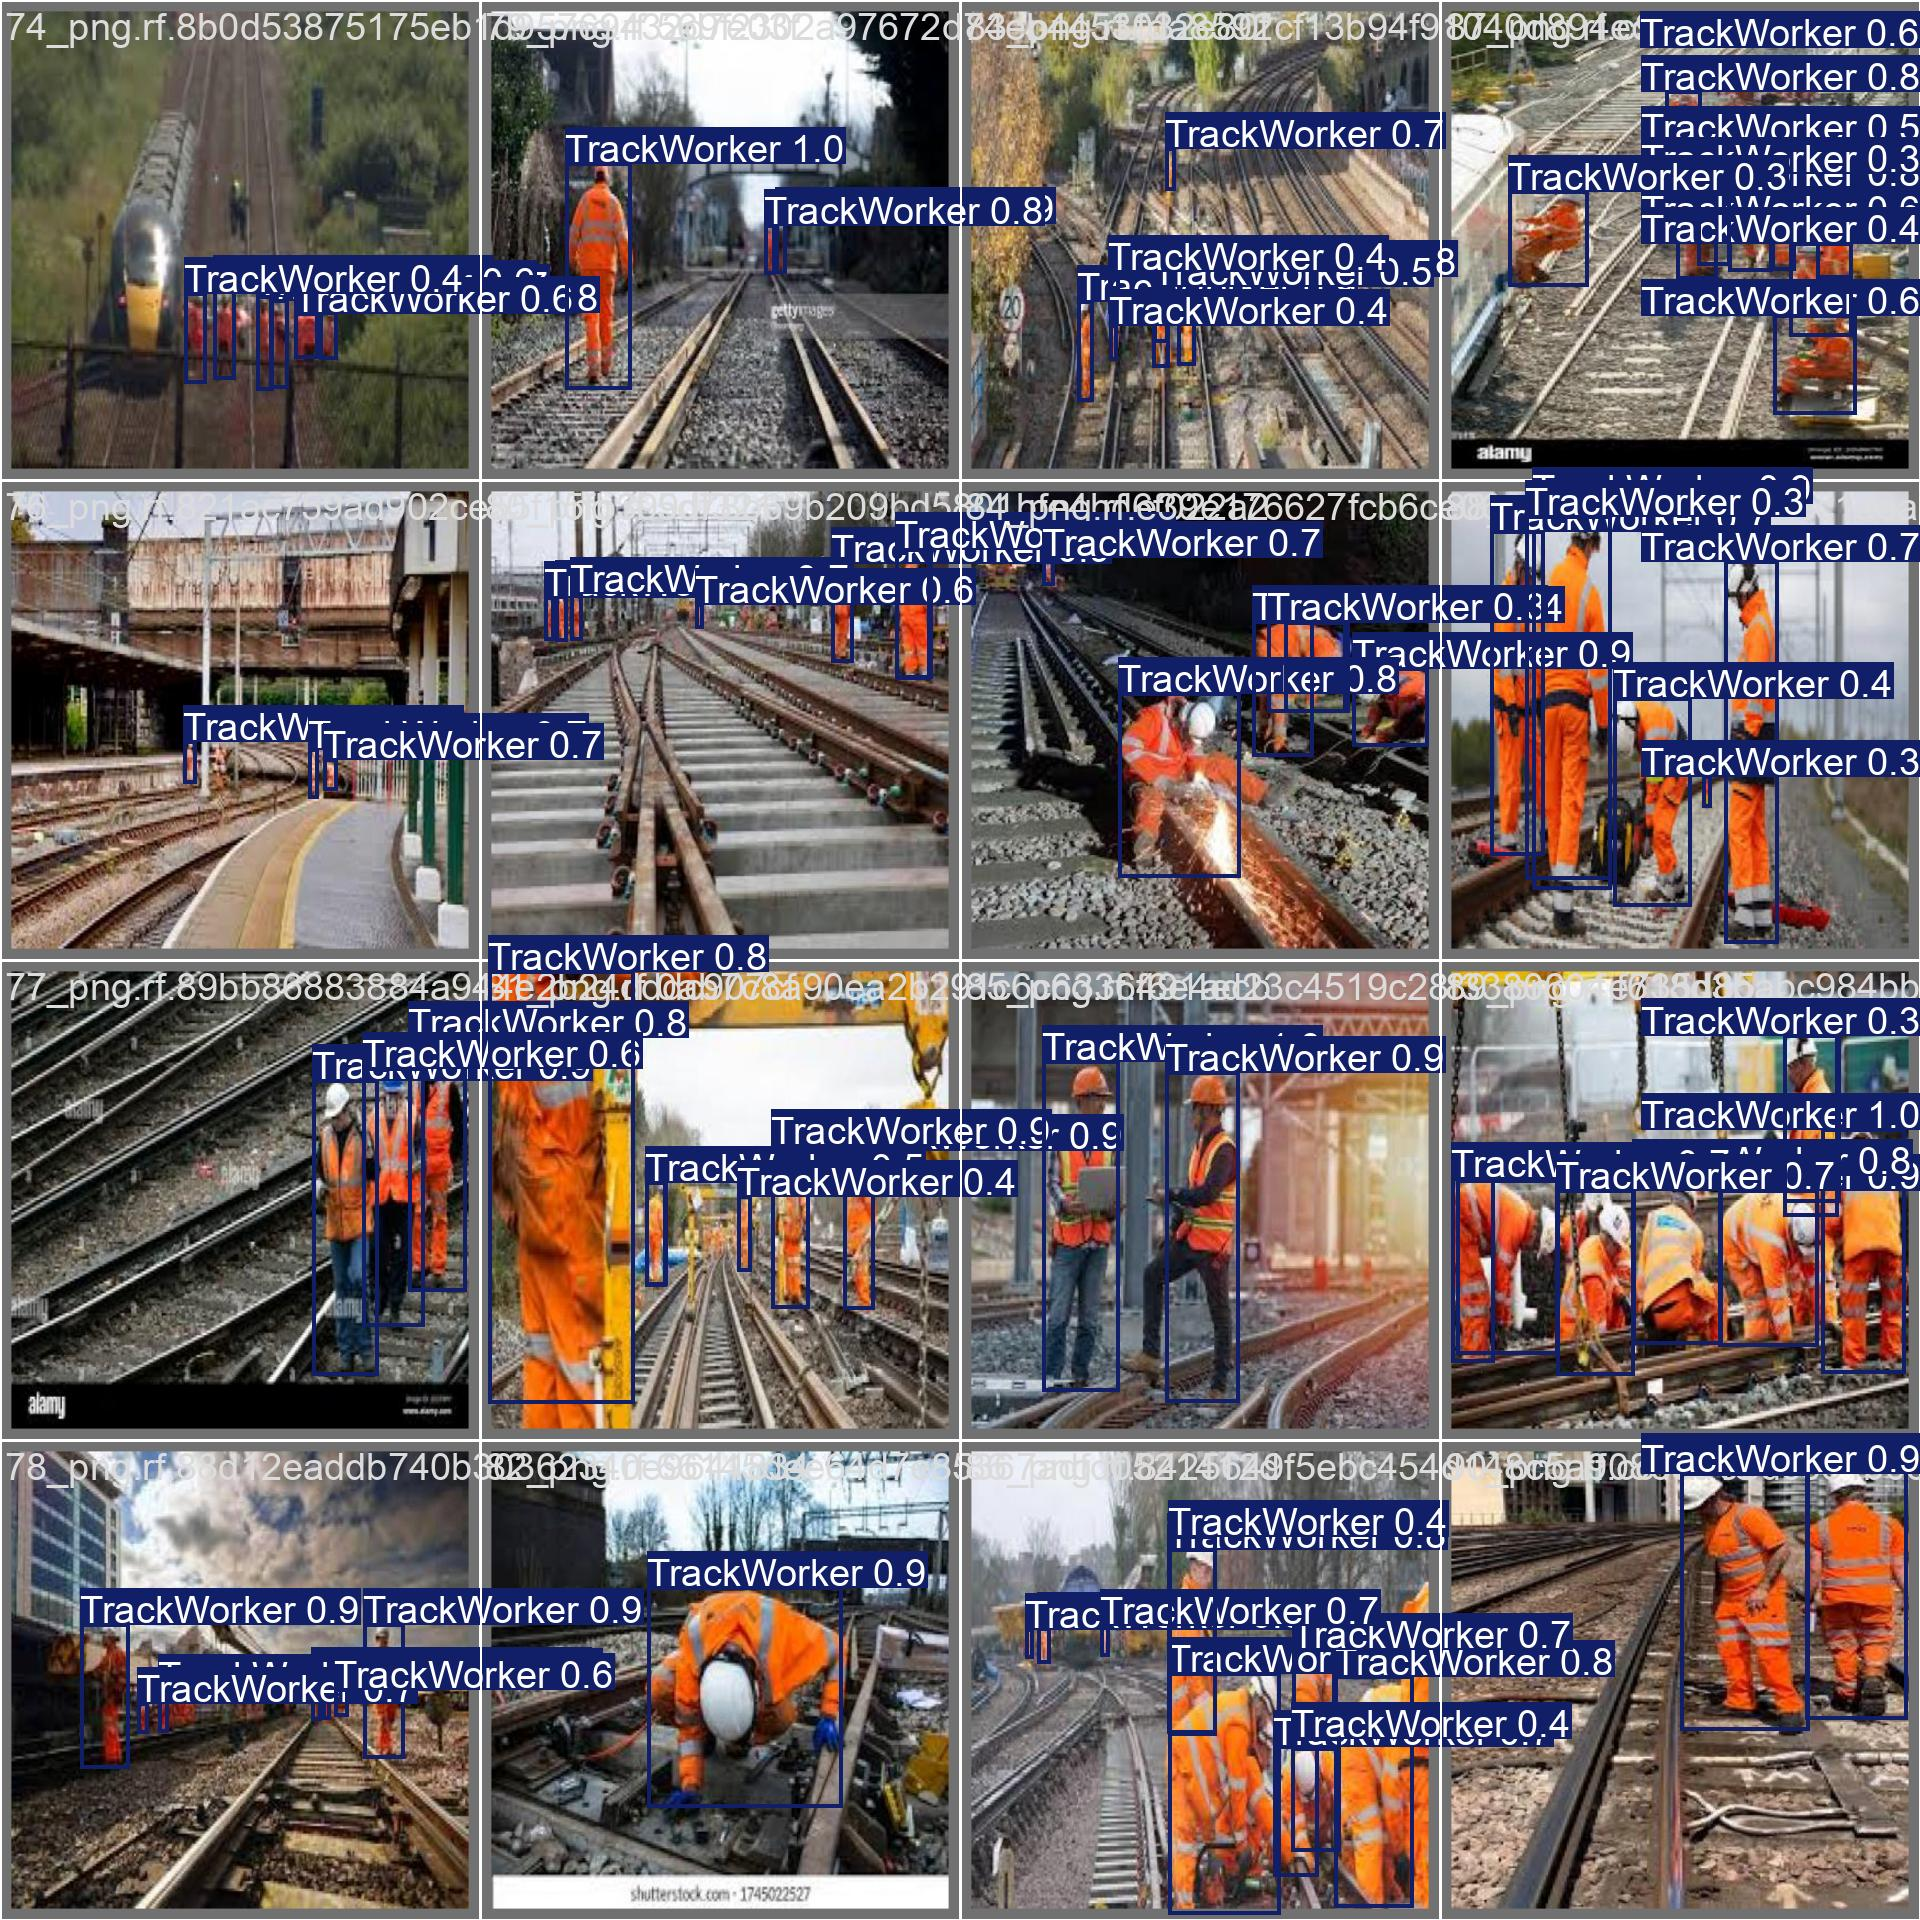

In [36]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [37]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLO26m summary (fused): 132 layers, 20,353,307 parameters, 0 gradients, 67.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1705.6±601.6 MB/s, size: 33.6 KB)
val: Scanning /content/Rail-6/valid/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 22.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.7it/s 4.1s
                   all        100        433      0.827      0.668      0.747      0.407
           AmberSignal         23         23      0.909      0.865      0.874      0.499
           GreenSignal         47         49      0.892      0.653      0.802      0.486
                Person         21        192      0.705      0.531      0.613      0.296
             RedSignal         21         24       0.87       0.56      0.652      0.324
           TrackWorker         31        145    

## Inference with custom model

### CLI

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt source={dataset.location}/test/images save=True verbose=False

Ultralytics 8.4.2 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO26m summary (fused): 132 layers, 20,357,162 parameters, 0 gradients, 67.9 GFLOPs
Results saved to /content/runs/detect/predict4
💡 Learn more at https://docs.ultralytics.com/modes/predict


### SDK

In [ ]:
from ultralytics import YOLO

model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Run inference on your video
from ultralytics import YOLO

# Load your trained model
model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')

# Path to your video in Google Drive
video_path = '/content/drive/MyDrive/your_video.mp4'  # Update this path

# Run inference
results = model.predict(
    source=video_path,
    save=True,              # Save annotated video
    conf=0.25,              # Confidence threshold
    iou=0.45,               # NMS IoU threshold
    show=False,             # Don't display (Colab doesn't support this well)
    stream=True,            # Use streaming for memory efficiency
    verbose=True            # Print progress
)

# Process results if needed
for result in results:
    # Access detection info for each frame if needed
    boxes = result.boxes  # Boxes object
    # Do something with results...
    pass

print("Inference complete! Check the output video in runs/detect/predict/")

In [50]:
import supervision as sv

ds_test = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

In [42]:
import supervision as sv
from PIL import Image

def annotate(image: Image.Image, detections: sv.Detections) -> Image.Image:
    color = sv.ColorPalette.from_hex([
        "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00",
        "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    ])

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    box_annotator = sv.BoxAnnotator(color=color)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        smart_position=True
    )

    out = image.copy()
    out = box_annotator.annotate(out, detections)
    out = label_annotator.annotate(out, detections)
    out.thumbnail((1000, 1000))
    return out

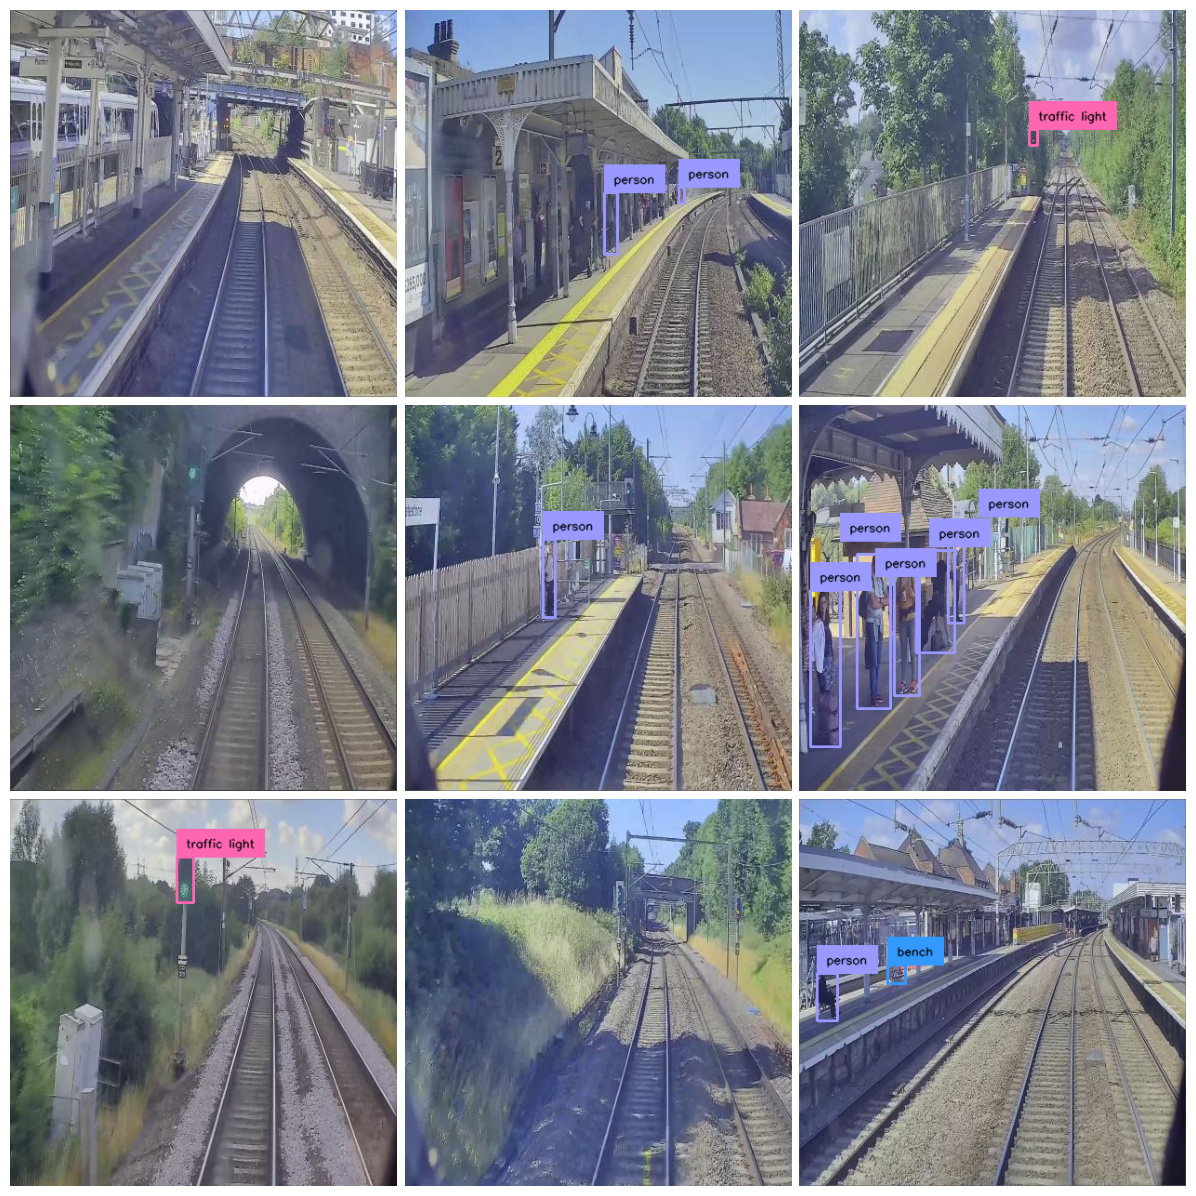

In [51]:
import random
import matplotlib.pyplot as plt

N = 9
L = len(ds_test)

annotated_images = []

for i in random.sample(range(L), N):
    path, _, annotations = ds_test[i]
    image = Image.open(path)
    result = model.predict(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(result)
    annotated_image = annotate(image, detections)
    annotated_images.append(annotated_image)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for ax, img in zip(axes.flat, annotated_images):
    ax.imshow(img)
    ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0.02, left=0.01, right=0.99, top=0.99, bottom=0.01)

plt.show()

In [52]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Run inference on your video
from ultralytics import YOLO

# Load your trained model
model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')

# Path to your video in Google Drive
video_path = '/content/drive/MyDrive/your_video.mp4'  # Update this path

# Run inference
results = model.predict(
    source=video_path,
    save=True,              # Save annotated video
    conf=0.25,              # Confidence threshold
    iou=0.45,               # NMS IoU threshold
    show=False,             # Don't display (Colab doesn't support this well)
    stream=True,            # Use streaming for memory efficiency
    verbose=True            # Print progress
)

# Process results if needed
for result in results:
    # Access detection info for each frame if needed
    boxes = result.boxes  # Boxes object
    # Do something with results...
    pass

print("Inference complete! Check the output video in runs/detect/predict/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



FileNotFoundError: /content/drive/MyDrive/your_video.mp4 does not exist

## Deploy model on Roboflow

Upload the YOLO26 weights to Roboflow Deploy for inference on Roboflow infrastructure built for scale.

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>